# ProteinMCP — Binder Design Workflow

Design protein binders using BindCraft with GPU-accelerated deep learning for de novo binder generation.

| Component | Description |
|-----------|-------------|
| **BindCraft** | De novo binder design using RFdiffusion + ProteinMPNN + AlphaFold2 |
| **Async Jobs** | GPU-accelerated design with asynchronous job submission and monitoring |
| **Quality Metrics** | pLDDT, pAE, interface scores, composite quality assessment |

**Prerequisites:** Docker (with GPU support), Claude Code CLI, ProteinMCP installed locally.

**Links:** [GitHub](https://github.com/charlesxu90/ProteinMCP) · [BindCraft](https://github.com/martinpacesa/BindCraft)

---

## Job configs

In [1]:
# ── User Configuration ──
TARGET_NAME = "PDL1"
TARGET_CHAINS = "A"
BINDER_LENGTH = 130
NUM_DESIGNS = 3

# Optional: set API key here or in .env. If unset, Claude CLI uses your logged-in account.
ANTHROPIC_API_KEY = ""
CLAUDE_MODEL = "claude-sonnet-4-6"

## Import utility and define functions

In [2]:
import os
import subprocess
import json
import select

# ---------- Streaming command runner ----------
def run_cmd(cmd, cwd=None):
    """Run a shell command and stream stdout/stderr line-by-line in real time."""
    proc = subprocess.Popen(
        cmd, shell=True, cwd=cwd,
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        bufsize=1, text=True,
    )
    for line in proc.stdout:
        print(line, end="", flush=True)
    proc.wait()
    if proc.returncode != 0:
        print(f"\n\u26a0\ufe0f  Command exited with code {proc.returncode}")
    return proc.returncode

# ---------- Claude streaming helper ----------
def _display_claude_line(line):
    """Parse a single stream-json line from Claude CLI and print progress."""
    if not line.strip():
        return
    try:
        data = json.loads(line)
        msg_type = data.get('type', '')
        subtype = data.get('subtype', '')

        if msg_type == 'system':
            if subtype == 'init':
                session_id = data.get('session_id', '')[:8]
                print(f"  \U0001f916 Session started: {session_id}...", flush=True)
            elif subtype != 'transcript':
                print(f"  \u2699\ufe0f  System: {subtype}", flush=True)

        elif msg_type == 'assistant':
            message = data.get('message', {})
            for block in message.get('content', []):
                block_type = block.get('type', '')
                if block_type == 'thinking':
                    text = block.get('thinking', '')[:100]
                    print(f"  \U0001f4ad Thinking: {text}...", flush=True)
                elif block_type == 'text':
                    lines = block.get('text', '').strip().split('\n')
                    for tl in lines[:5]:
                        if tl.strip():
                            print(f"  {tl}", flush=True)
                    if len(lines) > 5:
                        print(f"  ... ({len(lines) - 5} more lines)", flush=True)
                elif block_type == 'tool_use':
                    tool_name = block.get('name', 'unknown')
                    tool_input = block.get('input', {})
                    if tool_name == 'Bash':
                        print(f"  \U0001f527 Bash: {tool_input.get('command', '')[:80]}", flush=True)
                    elif tool_name in ('Read', 'Write', 'Edit'):
                        print(f"  \U0001f4d6 {tool_name}: {tool_input.get('file_path', '')}", flush=True)
                    elif tool_name.startswith('mcp__'):
                        print(f"  \U0001f50c MCP: {tool_name}", flush=True)
                    else:
                        print(f"  \U0001f527 {tool_name}", flush=True)

        elif msg_type == 'user':
            for block in data.get('message', {}).get('content', []):
                if block.get('type') == 'tool_result':
                    if block.get('is_error', False):
                        err = block.get('content', '')
                        err = err[:100] if isinstance(err, str) else str(err)[:100]
                        print(f"  \u274c Error: {err}", flush=True)
                    else:
                        content = block.get('content', '')
                        if isinstance(content, str) and content.strip():
                            first = content.strip().split('\n')[0][:80]
                            if first:
                                print(f"  \u2705 Result: {first}", flush=True)
                        else:
                            print(f"  \u2705 Done", flush=True)

        elif msg_type == 'result':
            if subtype == 'success':
                print(f"  \u2705 Completed successfully", flush=True)
            elif subtype == 'error':
                print(f"  \u274c Error: {data.get('error', 'Unknown')}", flush=True)

    except json.JSONDecodeError:
        if line.strip():
            print(f"  {line}", flush=True)


def run_claude(prompt, allowed_tools=None, cwd=None):
    """Run Claude CLI with real-time streaming output.

    Args:
        prompt: The prompt text to send to Claude (passed via stdin).
        allowed_tools: Comma-separated tool names, e.g. "Bash,Read,Write".
        cwd: Working directory for the claude process.

    Returns:
        Process return code (0 = success).
    """
    cmd = [
        "claude",
        "--model", CLAUDE_MODEL,
        "-p", "-",
        "--output-format", "stream-json",
        "--verbose",
        "--dangerously-skip-permissions",
    ]
    if allowed_tools:
        cmd += ["--allowedTools", allowed_tools]

    print(f"  \U0001f916 Claude model: {CLAUDE_MODEL}")
    print(f"  \U0001f4cb Tools: {allowed_tools or 'all'}")
    print(f"  " + "-" * 58)

    proc = subprocess.Popen(
        cmd, cwd=cwd,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True, bufsize=1,
    )
    proc.stdin.write(prompt)
    proc.stdin.close()

    while True:
        if proc.poll() is not None:
            # Drain remaining output
            for line in (proc.stdout.read() or '').split('\n'):
                _display_claude_line(line)
            for line in (proc.stderr.read() or '').split('\n'):
                if line.strip():
                    print(f"  \u2699\ufe0f  {line}", flush=True)
            break

        try:
            readable, _, _ = select.select([proc.stdout, proc.stderr], [], [], 0.1)
        except (ValueError, OSError):
            break

        for stream in readable:
            line = stream.readline()
            if line:
                if stream == proc.stdout:
                    _display_claude_line(line.rstrip('\n'))
                else:
                    if line.strip():
                        print(f"  \u2699\ufe0f  {line.rstrip()}", flush=True)

    rc = proc.wait()
    print(f"  " + "-" * 58)
    if rc != 0:
        print(f"  \u26a0\ufe0f  Claude exited with code {rc}")
    return rc

## Setup and verify the environment

In [3]:
import shutil

# ---------- Paths ----------
# Auto-detect REPO_DIR: walk up from notebook location to find project root
_nb_dir = os.path.abspath("")
if os.path.basename(_nb_dir) == "notebooks":
    REPO_DIR = os.path.dirname(_nb_dir)
else:
    REPO_DIR = _nb_dir

# ---------- Load API key from .env if not set ----------
if not ANTHROPIC_API_KEY:
    _env_file = os.path.join(REPO_DIR, ".env")
    if os.path.exists(_env_file):
        with open(_env_file) as f:
            for line in f:
                line = line.strip()
                if line.startswith("ANTHROPIC_API_KEY="):
                    ANTHROPIC_API_KEY = line.split("=", 1)[1].strip().strip("\"'")
                    break
        if ANTHROPIC_API_KEY:
            print(f"Loaded ANTHROPIC_API_KEY from {_env_file}")

if ANTHROPIC_API_KEY:
    os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY
    print(f"Using API key (ends with ...{ANTHROPIC_API_KEY[-4:]})")
else:
    print("No API key set — Claude CLI will use your logged-in account.")

# ---------- Data paths ----------
EXAMPLE_DIR = os.path.join(REPO_DIR, "examples", "case2_binder_design")
DATA_DIR    = os.path.join(REPO_DIR, "data", TARGET_NAME)
RESULTS_DIR = os.path.join(REPO_DIR, "results", f"{TARGET_NAME}_binder")
TARGET_PDB  = os.path.join(DATA_DIR, f"{TARGET_NAME}.pdb")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "designs"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "logs"), exist_ok=True)

# Copy example PDB into DATA_DIR
src_pdb = os.path.join(EXAMPLE_DIR, f"{TARGET_NAME}.pdb")
if os.path.exists(src_pdb) and not os.path.exists(TARGET_PDB):
    shutil.copy2(src_pdb, TARGET_PDB)
    print(f"Copied {src_pdb} \u2192 {TARGET_PDB}")

assert os.path.exists(TARGET_PDB), f"Target PDB not found: {TARGET_PDB}"

print(f"\nCLAUDE_MODEL   : {CLAUDE_MODEL}")
print(f"TARGET_NAME    : {TARGET_NAME}")
print(f"TARGET_CHAINS  : {TARGET_CHAINS}")
print(f"BINDER_LENGTH  : {BINDER_LENGTH}")
print(f"NUM_DESIGNS    : {NUM_DESIGNS}")
print(f"REPO_DIR       : {REPO_DIR}")
print(f"DATA_DIR       : {DATA_DIR}")
print(f"RESULTS_DIR    : {RESULTS_DIR}")
print(f"TARGET_PDB     : {TARGET_PDB}")

No API key set — Claude CLI will use your logged-in account.

CLAUDE_MODEL   : claude-sonnet-4-6
TARGET_NAME    : PDL1
TARGET_CHAINS  : A
BINDER_LENGTH  : 130
NUM_DESIGNS    : 3
REPO_DIR       : /home/xux/Desktop/AgentMCP/ProteinMCP
DATA_DIR       : /home/xux/Desktop/AgentMCP/ProteinMCP/data/PDL1
RESULTS_DIR    : /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder
TARGET_PDB     : /home/xux/Desktop/AgentMCP/ProteinMCP/data/PDL1/PDL1.pdb


## Install & Register MCPs

> **Tip — Local Docker build:** The `bindcraft_mcp` Docker image is large and may time out
> during `pmcp install`. You can build and register it locally instead:
> ```bash
> cd tool-mcps/bindcraft_mcp && docker build -t bindcraft_mcp:latest . && cd ../..
> claude mcp add bindcraft_mcp -- docker run -i --rm --gpus all --ipc=host -v $PWD:$PWD bindcraft_mcp:latest
> ```
> The install cell below will skip if `bindcraft_mcp` is already registered.

In [4]:
import time
_t0 = time.time()

# Install ProteinMCP if not already present
if run_cmd("which pmcp") != 0:
    run_cmd(f"pip install -e {REPO_DIR}")
    run_cmd(f"pip install -r {REPO_DIR}/requirements.txt")
else:
    print("ProteinMCP already installed.")

# Install Claude Code if not already present
if run_cmd("which claude") != 0:
    run_cmd("npm install -g @anthropic-ai/claude-code")
else:
    print("Claude Code already installed.")

# Verify Docker is available (required for bindcraft_mcp)
if run_cmd("docker --version") != 0:
    print("WARNING: Docker not found. bindcraft_mcp requires Docker with GPU support.")
else:
    print("Docker found.")

print(f"\nProteinMCP & Claude Code ready.")
print(f"Elapsed: {time.time() - _t0:.1f}s")

/home/xux/miniforge3/envs/protein-mcp/bin/pmcp
ProteinMCP already installed.
/home/xux/.local/bin/claude
Claude Code already installed.
Docker version 29.2.1, build a5c7197
Docker found.

ProteinMCP & Claude Code ready.
Elapsed: 0.0s


In [5]:
import time
_t0 = time.time()

# Check if bindcraft_mcp is already registered
_registered = subprocess.run(["claude", "mcp", "list"], capture_output=True, text=True).stdout
if "bindcraft_mcp" not in _registered:
    print("Installing bindcraft_mcp (this may take a while for the Docker image pull)...")
    run_cmd("pmcp install bindcraft_mcp", cwd=REPO_DIR)
else:
    print("bindcraft_mcp already registered. Skipping installation.")

# Verify MCP status
print(f"\n{'='*50}")
run_cmd("claude mcp list", cwd=REPO_DIR)
print(f"\nElapsed: {time.time() - _t0:.1f}s")

bindcraft_mcp already registered. Skipping installation.

Checking MCP server health...

msa_mcp: python /mnt/data/done_projects/2026/BioMolMCP/ProteinMCP/tool-mcps/msa_mcp/src/server.py - ✓ Connected
plmc_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP plmc_mcp:latest - ✓ Connected
ev_onehot_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP ev_onehot_mcp:latest - ✓ Connected
prottrans_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -e HOME=/home/xux -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP -v /home/xux/.cache:/home/xux/.cache prottrans_mcp:latest - ✓ Connected
bindcraft_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP bindcraft_mcp:latest 

## Step 1 — Explore Default Configurations

In [6]:
import time
_t0 = time.time()

prompt = f"""\
Can you show me the available default configurations for BindCraft using the \
bindcraft_mcp server? I want to understand what settings are available for \
binder design. Use the generate_config tool with analysis_type="basic" and \
input_file={TARGET_PDB} to see what settings are generated.
"""

run_claude(
    prompt,
    allowed_tools="mcp__bindcraft_mcp__generate_config,Bash,Read",
    cwd=REPO_DIR,
)

print(f"\nElapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__bindcraft_mcp__generate_config,Bash,Read
  ----------------------------------------------------------
  🤖 Session started: f8826c1a...
  💭 Thinking: The user wants to see the default configurations for BindCraft using the generate_config tool with s...
  🔌 MCP: mcp__bindcraft_mcp__generate_config
  ✅ Result: {"status":"success","success":true,"result":{"files_generated":["target_settings
  Here's a summary of what was generated:
  ## BindCraft Default Configuration for PDL1
  ### PDB Analysis
  ... (31 more lines)
  ✅ Completed successfully
  ----------------------------------------------------------

Elapsed: 49.2s


## Step 2 — Generate Configuration

In [7]:
import time
_t0 = time.time()

CONFIG_DIR = os.path.join(RESULTS_DIR, "config")

prompt = f"""\
Generate a BindCraft configuration for my target protein at {TARGET_PDB}. \
Target chain(s) {TARGET_CHAINS} and aim for a binder of length {BINDER_LENGTH}. \
Generate {NUM_DESIGNS} designs. \
Save the config to the output directory {CONFIG_DIR}. \
IMPORTANT: The output_file parameter is an output DIRECTORY path, not a file path. \
Please convert relative paths to absolute paths before calling the MCP server.
"""

run_claude(
    prompt,
    allowed_tools="mcp__bindcraft_mcp__generate_config,Bash,Read,Write",
    cwd=REPO_DIR,
)

# Verify config was created — generate_config creates output_dir/target_settings.json
config_settings = os.path.join(CONFIG_DIR, "target_settings.json")

# Find target_settings.json: check expected location, then search recursively
config = None
if os.path.isfile(config_settings):
    with open(config_settings) as f:
        config = json.load(f)
    print(f"\nConfig generated: {config_settings}")
elif os.path.isdir(CONFIG_DIR):
    for root, dirs, files in os.walk(CONFIG_DIR):
        if "target_settings.json" in files:
            found = os.path.join(root, "target_settings.json")
            with open(found) as f:
                config = json.load(f)
            config_settings = found
            print(f"\nConfig generated: {found}")
            break
elif os.path.isfile(CONFIG_DIR):
    with open(CONFIG_DIR) as f:
        config = json.load(f)
    print(f"\nConfig generated: {CONFIG_DIR}")

if config:
    print(f"Config keys: {list(config.keys())}")
    # Track the BindCraft output directory (design_path from settings)
    BINDCRAFT_OUTPUT_DIR = config.get("design_path", os.path.join(CONFIG_DIR, "job_output"))
    print(f"BindCraft output dir: {BINDCRAFT_OUTPUT_DIR}")
else:
    print(f"\nWARNING: Config not found at {CONFIG_DIR}")
    print("The design job in the next step will use default settings.")
    BINDCRAFT_OUTPUT_DIR = os.path.join(CONFIG_DIR, "job_output")

print(f"Elapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__bindcraft_mcp__generate_config,Bash,Read,Write
  ----------------------------------------------------------
  🤖 Session started: 09e60c46...
  💭 Thinking: The user wants to generate a BindCraft configuration for a target protein. Let me call the generate_...
  🔌 MCP: mcp__bindcraft_mcp__generate_config
  ✅ Result: {"status":"success","success":true,"result":{"files_generated":["target_settings
  Configuration generated successfully. Here's a summary:
  **Config saved to:** `/home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/`
  **Files generated:**
  ... (16 more lines)
  ✅ Completed successfully
  ----------------------------------------------------------

Config generated: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/target_settings.json
Config keys: ['design_path', 'binder_name', 'starting_pdb', 'chains', 'target_hotspot_residues', 'lengths', 'number_of_final_designs', '_metadata']
BindCraft output

## Step 3 — Launch Binder Design Job

> **Note:** The design job is launched directly via `docker run` (detached) rather
> than through `bindcraft_submit`, because the MCP Docker container uses `--rm` and
> is killed when the Claude CLI session ends — which would kill the background
> `run_bindcraft.py` process. Running the container in detached mode (`-d`) ensures
> the GPU job survives across notebook cells.

In [8]:
import time
_t0 = time.time()

_settings_file = os.path.join(RESULTS_DIR, "config", "target_settings.json")
assert os.path.isfile(_settings_file), f"Settings file not found: {_settings_file}"

# Read config to get BINDCRAFT_OUTPUT_DIR
with open(_settings_file) as f:
    config = json.load(f)
BINDCRAFT_OUTPUT_DIR = config["design_path"]
os.makedirs(BINDCRAFT_OUTPUT_DIR, exist_ok=True)
print(f"Settings file : {_settings_file}")
print(f"Output dir    : {BINDCRAFT_OUTPUT_DIR}")

# Launch BindCraft in a detached Docker container (survives notebook cell transitions)
CONTAINER_NAME = f"bindcraft_job_{TARGET_NAME}"

# Kill any previous container with the same name
subprocess.run(["docker", "rm", "-f", CONTAINER_NAME], capture_output=True)

docker_cmd = [
    "docker", "run", "-d",
    "--name", CONTAINER_NAME,
    "--user", f"{os.getuid()}:{os.getgid()}",
    "--gpus", "all", "--ipc=host",
    "-v", f"{REPO_DIR}:{REPO_DIR}",
    "bindcraft_mcp:latest",
    "python", "/app/scripts/run_bindcraft.py",
    f"--settings={_settings_file}",
    "--filters=/app/repo/BindCraft/settings_filters/default_filters.json",
    "--advanced=/app/repo/BindCraft/settings_advanced/default_4stage_multimer.json",
]

result = subprocess.run(docker_cmd, capture_output=True, text=True)
if result.returncode == 0:
    container_id = result.stdout.strip()[:12]
    print(f"\nContainer launched: {container_id} ({CONTAINER_NAME})")
    print("GPU job is running in the background. Use the polling cell to monitor.")
else:
    print(f"ERROR launching container:\n{result.stderr}")

print(f"Elapsed: {time.time() - _t0:.1f}s")

Settings file : /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/target_settings.json
Output dir    : /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/job_output

Container launched: 36564450d8b8 (bindcraft_job_PDL1)
GPU job is running in the background. Use the polling cell to monitor.
Elapsed: 5.5s


## Step 4 — Monitor Job Progress

In [9]:
import time
_t0 = time.time()

# Ensure BINDCRAFT_OUTPUT_DIR is set from config (in case cells run out of order)
_settings_file = os.path.join(RESULTS_DIR, "config", "target_settings.json")
if os.path.isfile(_settings_file):
    with open(_settings_file) as f:
        _cfg = json.load(f)
    BINDCRAFT_OUTPUT_DIR = _cfg["design_path"]

LOG_FILE = os.path.join(BINDCRAFT_OUTPUT_DIR, "bindcraft_run.log")
CONTAINER_NAME = f"bindcraft_job_{TARGET_NAME}"

# Check container status
_cstatus = subprocess.run(
    ["docker", "inspect", "-f", "{{.State.Status}}", CONTAINER_NAME],
    capture_output=True, text=True
).stdout.strip()
print(f"Container '{CONTAINER_NAME}' status: {_cstatus or 'not found'}")

# Check GPU
_gpu = subprocess.run(
    ["nvidia-smi", "--query-gpu=index,utilization.gpu,memory.used", "--format=csv,noheader"],
    capture_output=True, text=True
).stdout.strip()
print(f"GPU status: {_gpu}")

# Show recent log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE) as f:
        lines = f.readlines()
    print(f"\nLog ({len(lines)} lines), last 10:")
    for line in lines[-10:]:
        print(f"  {line.rstrip()}")
else:
    print(f"\nNo log file yet at {LOG_FILE}")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

Container 'bindcraft_job_PDL1' status: running
GPU status: 0, 0 %, 439 MiB
1, 0 %, 17 MiB

Log (16 lines), last 10:
  │               (C) Copyright Rosetta Commons Member Institutions               │
  │                                                                               │
  │ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRES PURCHASE OF A LICENSE │
  │          See LICENSE.PyRosetta.md or email license@uw.edu for details         │
  └───────────────────────────────────────────────────────────────────────────────┘
  PyRosetta-4 2026 [Rosetta PyRosetta4.conda.ubuntu.cxx11thread.serialization.Ubuntu.python310.Release 2026.06+release.1a56185c2592611dec4c9c75ddc9468cd2227c1f 2026-01-30T13:14:27] retrieved from: http://www.pyrosetta.org
  Running binder design for target target_settings
  Design settings used: default_4stage_multimer
  Filtering designs based on default_filters
  Starting trajectory: PDL1_Binder_l130_s575995

Elapsed: 0.1s


### Polling Loop (Optional)

Run this cell to poll job status every 5 minutes until the job completes.
Interrupt the kernel to stop polling early.

In [10]:
import time

POLL_INTERVAL = 300  # seconds (5 minutes)
MAX_POLLS = 60       # stop after 5 hours

# Ensure paths are set from config
_settings_file = os.path.join(RESULTS_DIR, "config", "target_settings.json")
if os.path.isfile(_settings_file):
    with open(_settings_file) as f:
        _cfg = json.load(f)
    BINDCRAFT_OUTPUT_DIR = _cfg["design_path"]

LOG_FILE = os.path.join(BINDCRAFT_OUTPUT_DIR, "bindcraft_run.log")
FINAL_CSV = os.path.join(BINDCRAFT_OUTPUT_DIR, "final_design_stats.csv")
CONTAINER_NAME = f"bindcraft_job_{TARGET_NAME}"

print(f"Polling {BINDCRAFT_OUTPUT_DIR} every {POLL_INTERVAL//60} min (Ctrl+C to stop)\n")

for i in range(1, MAX_POLLS + 1):
    # Check CSV line counts
    import pandas as pd
    n_final = 0
    if os.path.exists(FINAL_CSV):
        try:
            df_final = pd.read_csv(FINAL_CSV)
            n_final = len(df_final)
        except Exception:
            pass

    # Check container status
    _cstatus = subprocess.run(
        ["docker", "inspect", "-f", "{{.State.Status}}", CONTAINER_NAME],
        capture_output=True, text=True
    ).stdout.strip()

    # Read last log line for current stage
    last_line = ""
    if os.path.exists(LOG_FILE):
        with open(LOG_FILE) as f:
            lines = f.readlines()
            if lines:
                last_line = lines[-1].strip()[:120]

    ts = time.strftime("%H:%M:%S")
    print(f"[{ts}] Poll #{i}: accepted={n_final}/{NUM_DESIGNS} container={_cstatus} | {last_line}")

    # Check completion
    if n_final >= NUM_DESIGNS:
        print(f"\nAll {NUM_DESIGNS} designs accepted! Job complete.")
        break

    if "Finished all designs" in last_line:
        print(f"\nJob finished (found {n_final} accepted designs).")
        break

    # Check if container exited (job crashed or completed)
    if _cstatus == "exited":
        _exit_code = subprocess.run(
            ["docker", "inspect", "-f", "{{.State.ExitCode}}", CONTAINER_NAME],
            capture_output=True, text=True
        ).stdout.strip()
        if n_final < NUM_DESIGNS:
            print(f"\nContainer exited (code {_exit_code}) with only {n_final} accepted designs.")
            print("Check log for errors: tail -30", LOG_FILE)
        break

    if not _cstatus or _cstatus == "not found":
        print(f"\nContainer not found. Job may not have started.")
        break

    time.sleep(POLL_INTERVAL)
else:
    print(f"\nMax polls reached ({MAX_POLLS}). Check status manually.")

Polling /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/job_output every 5 min (Ctrl+C to stop)

[09:30:56] Poll #1: accepted=0/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[09:35:56] Poll #2: accepted=0/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[09:40:56] Poll #3: accepted=0/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[09:45:57] Poll #4: accepted=0/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[09:50:57] Poll #5: accepted=0/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[09:55:57] Poll #6: accepted=0/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[10:00:57] Poll #7: accepted=1/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[10:05:57] Poll #8: accepted=1/3 container=running | Starting trajectory: PDL1_Binder_l130_s575995
[10:10:57] Poll #9: accepted=1/3 container=running | Starting trajectory: PDL1_Binder_l130_s57

## Step 5 — Retrieve Results

In [11]:
import time
import pandas as pd
_t0 = time.time()

# Use bindcraft_check_status to get final results
prompt = f"""\
Check the final results of my completed BindCraft job. \
The output directory is {BINDCRAFT_OUTPUT_DIR}. \
Use bindcraft_check_status to get design counts and metrics. \
Also list the ranked PDB files in {BINDCRAFT_OUTPUT_DIR}/Accepted/Ranked/.
"""

run_claude(
    prompt,
    allowed_tools="mcp__bindcraft_mcp__bindcraft_check_status,Bash,Read",
    cwd=REPO_DIR,
)

# Print metrics from the correct location (BINDCRAFT_OUTPUT_DIR, not RESULTS_DIR/designs/)
for name in ["final_design_stats.csv", "mpnn_design_stats.csv"]:
    csv_path = os.path.join(BINDCRAFT_OUTPUT_DIR, name)
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        if len(df) > 0:
            # Show key metrics columns only
            key_cols = ['Rank', 'Design', 'Length', 'Average_pLDDT', 'Average_pTM',
                        'Average_i_pTM', 'Average_pAE', 'Average_i_pAE', 'Average_dG',
                        'Average_dSASA']
            display_cols = [c for c in key_cols if c in df.columns]
            print(f"\n{name} ({len(df)} designs):")
            print(df[display_cols].to_string(index=False))
        else:
            print(f"\n{name}: empty (no designs passed filters)")

# List ranked PDB files
ranked_dir = os.path.join(BINDCRAFT_OUTPUT_DIR, "Accepted", "Ranked")
if os.path.isdir(ranked_dir):
    ranked_files = sorted(os.listdir(ranked_dir))
    print(f"\nRanked PDB files ({len(ranked_files)}):")
    for f in ranked_files:
        print(f"  {f}")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__bindcraft_mcp__bindcraft_check_status,Bash,Read
  ----------------------------------------------------------
  🤖 Session started: e0b7539a...
  💭 Thinking: Let me check the BindCraft job status and list the ranked PDB files in parallel....
  🔌 MCP: mcp__bindcraft_mcp__bindcraft_check_status
  ✅ Result: {"status":"success","job_status":"stalled_or_completed","output_dir":"/home/xux/
  🔧 Glob
  ✅ Result: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/job_output/Acce
  Here's a summary of your completed PDL1 BindCraft job:
  ## Job Results
  | Metric | Count |
  ... (23 more lines)
  ✅ Completed successfully
  ----------------------------------------------------------

final_design_stats.csv (3 designs):
 Rank                    Design  Length  Average_pLDDT  Average_pTM  Average_i_pTM  Average_pAE  Average_i_pAE  Average_dG  Average_dSASA
    1 Binder_l130_s238931_mpnn9     130           0.92         0.82           0.7

## Step 6 — Visualize Results

Loaded BindCraft metrics from /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/config/job_output/final_design_stats.csv (3 designs)
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_plddt_comparison.png, /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_plddt_comparison.pdf
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_interface_pae.png, /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_interface_pae.pdf
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_metrics_table.png, /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_metrics_table.pdf
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_quality_scatter.png, /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_quality_scatter.pdf
Saved: /home/xux/Desktop/AgentMCP/ProteinMCP/results/PDL1_binder/binder_design_design_ranking.png

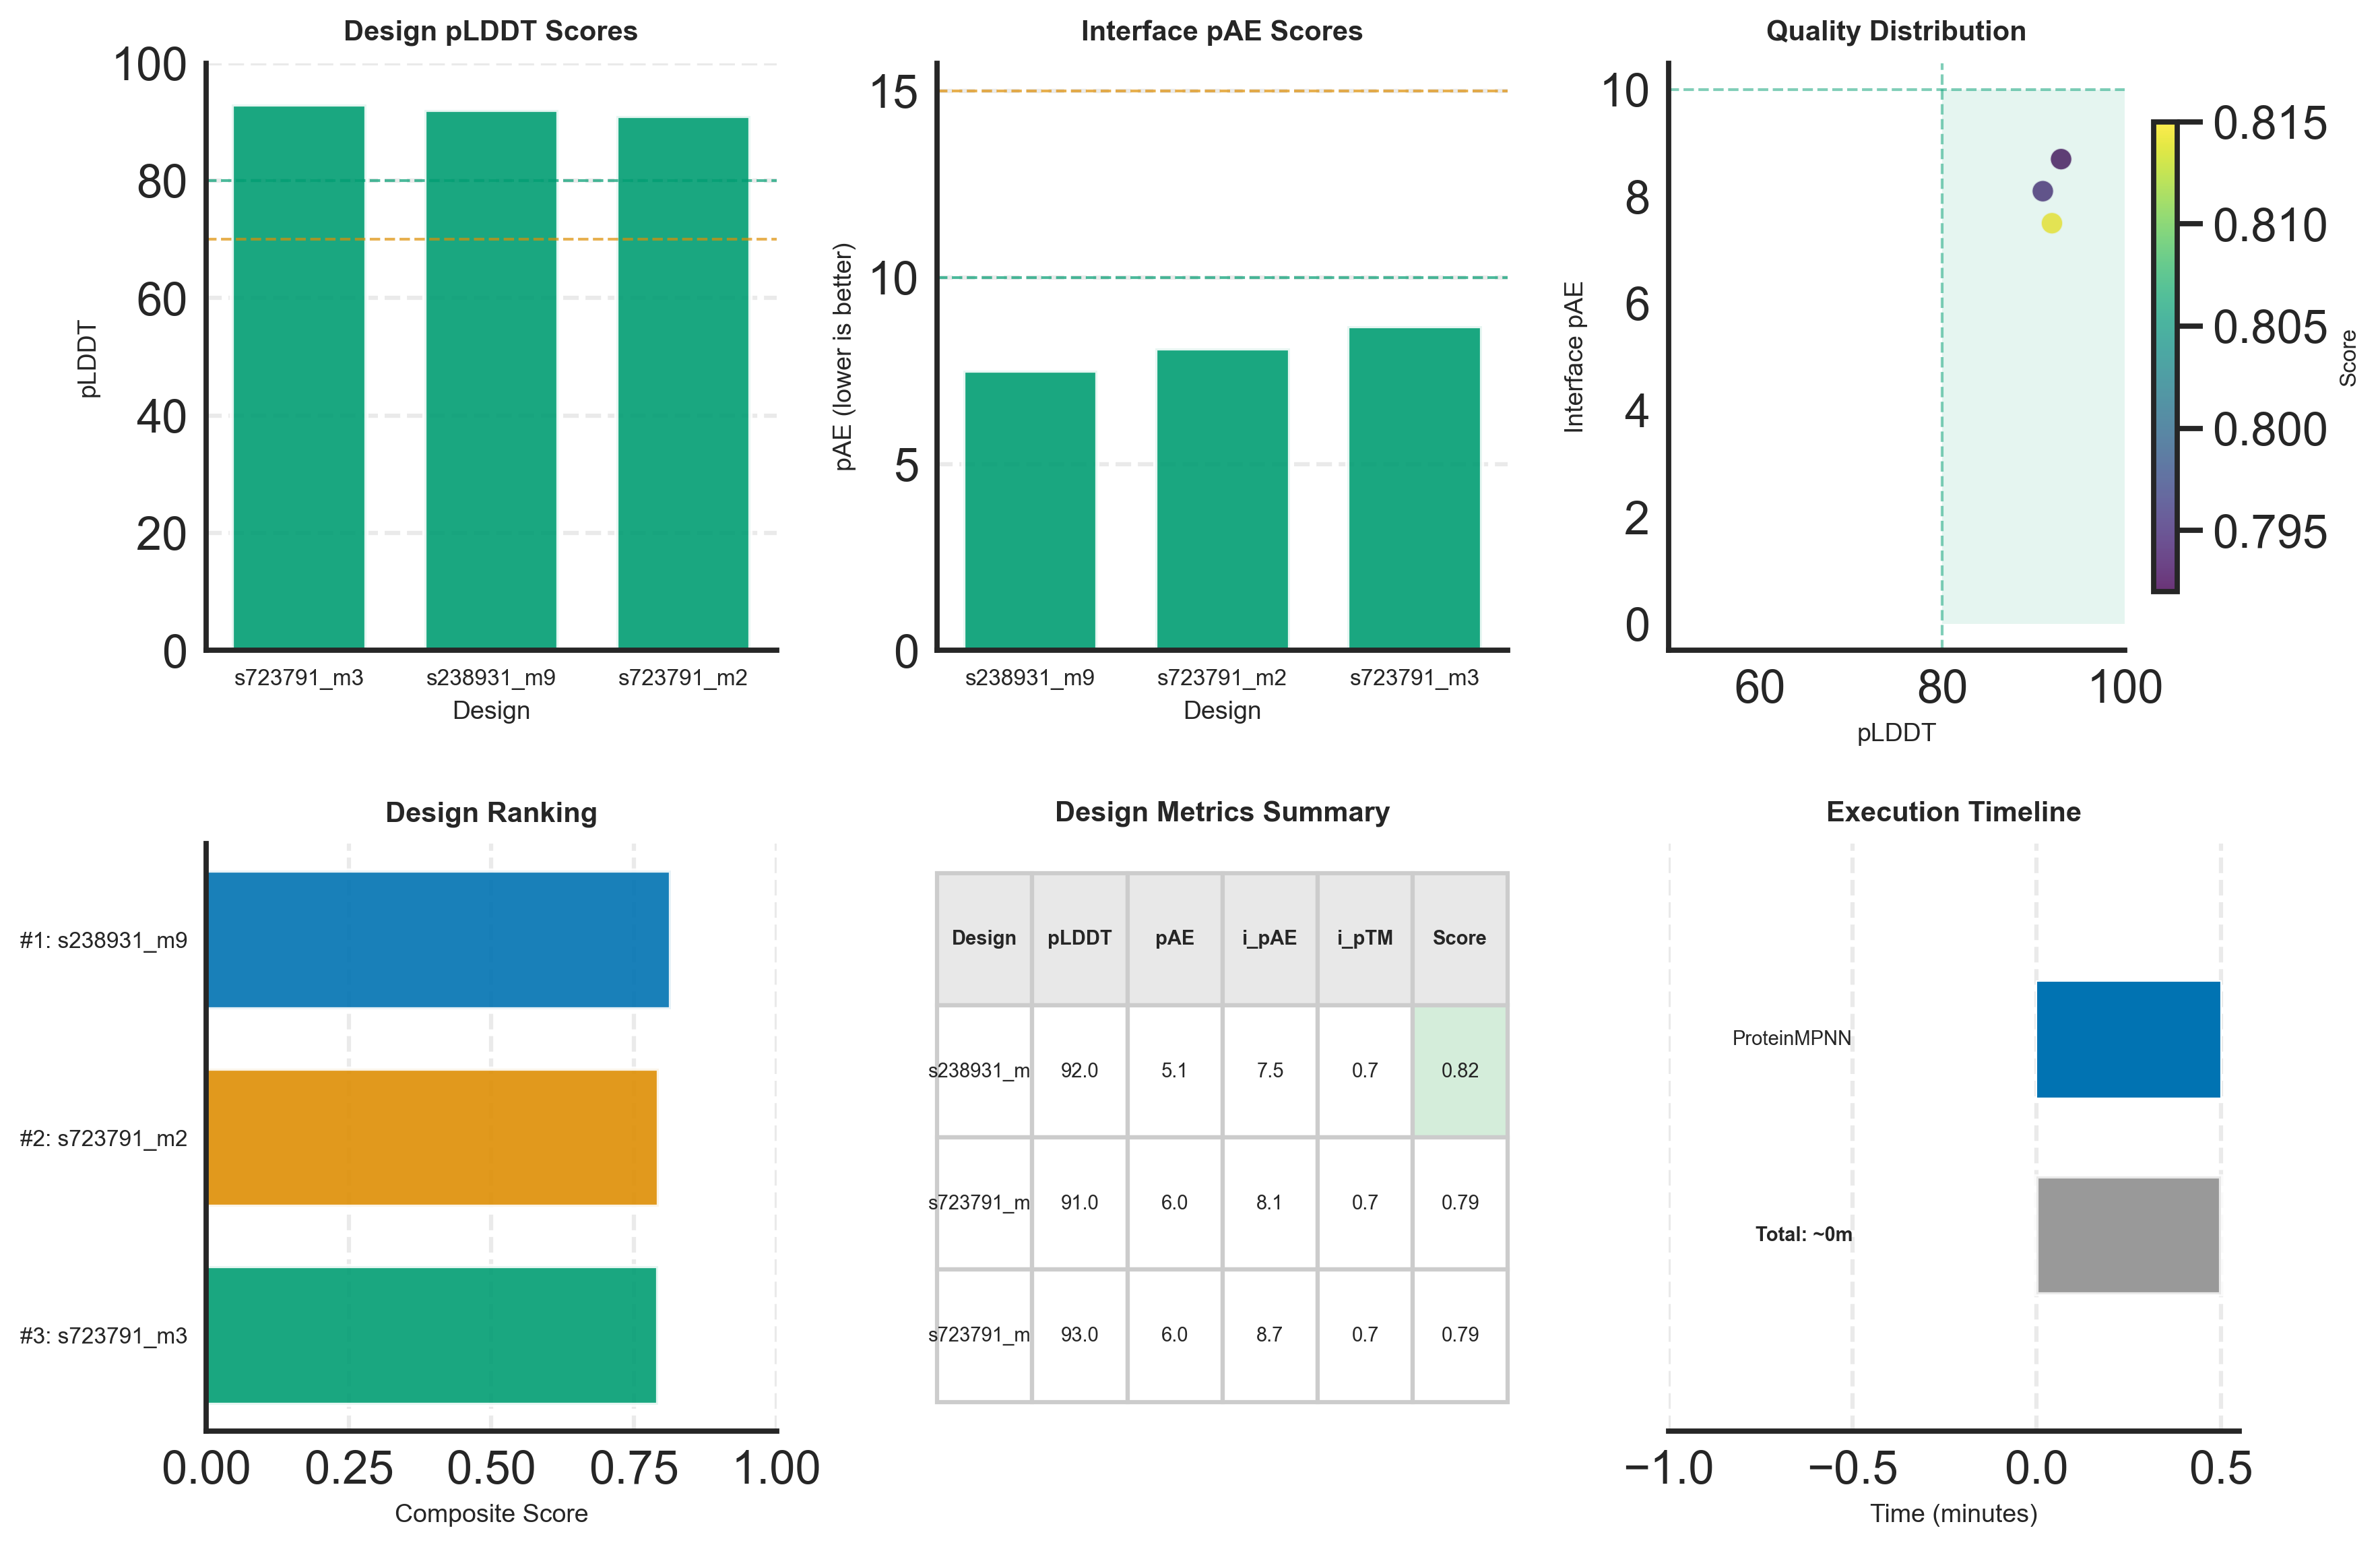


plddt_comparison:


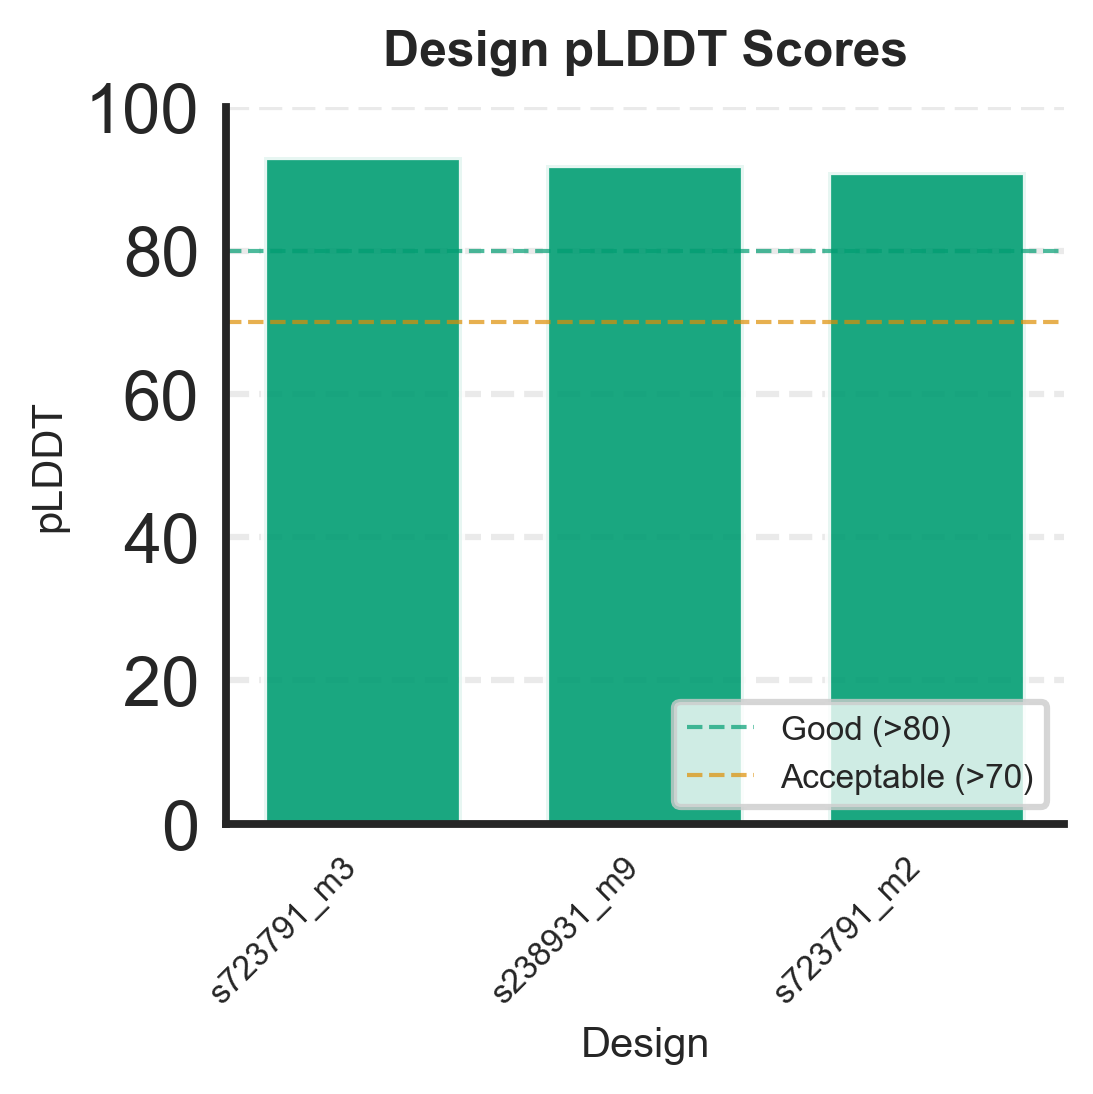


interface_pae:


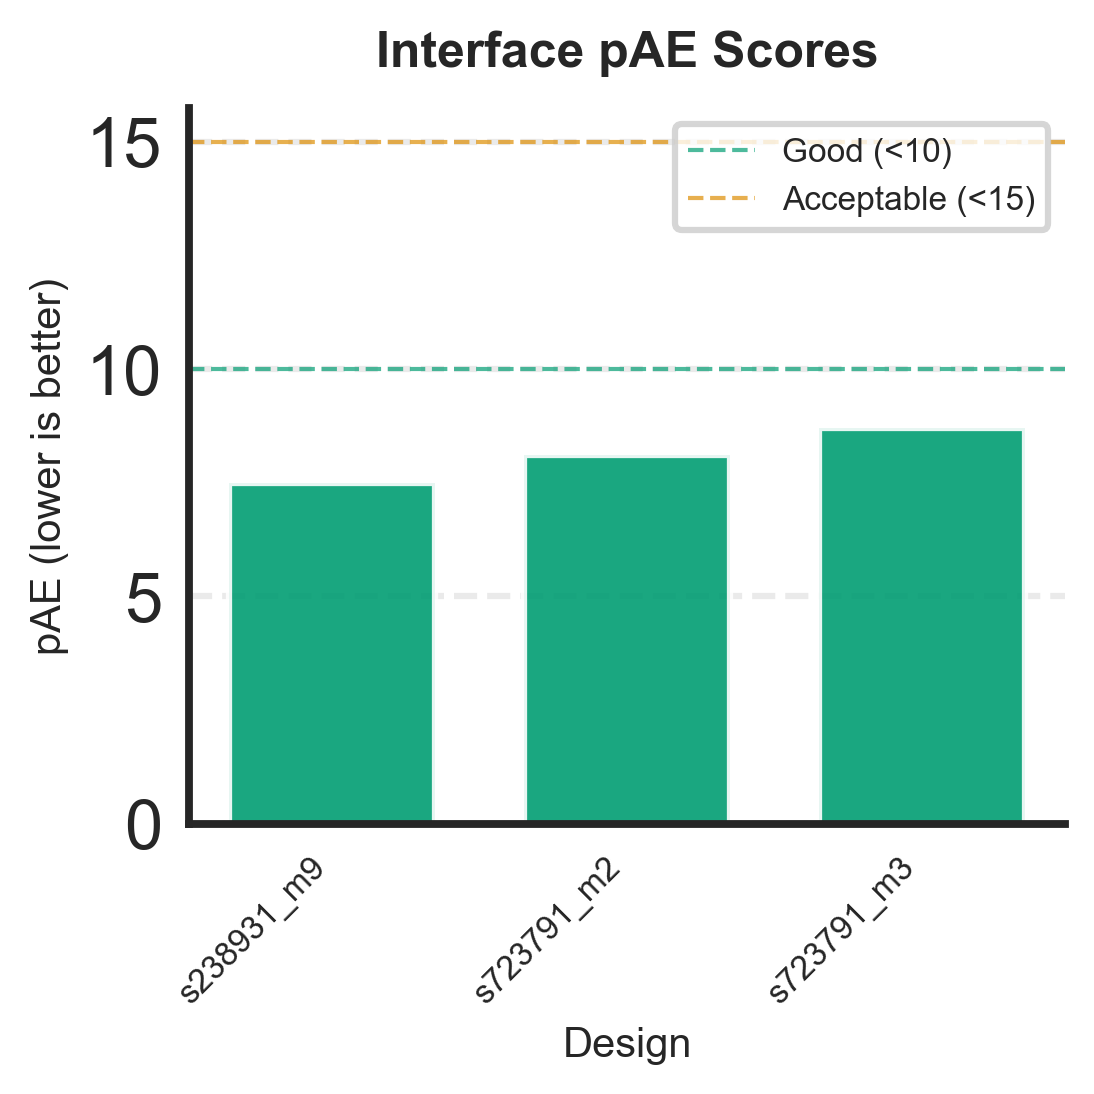


quality_scatter:


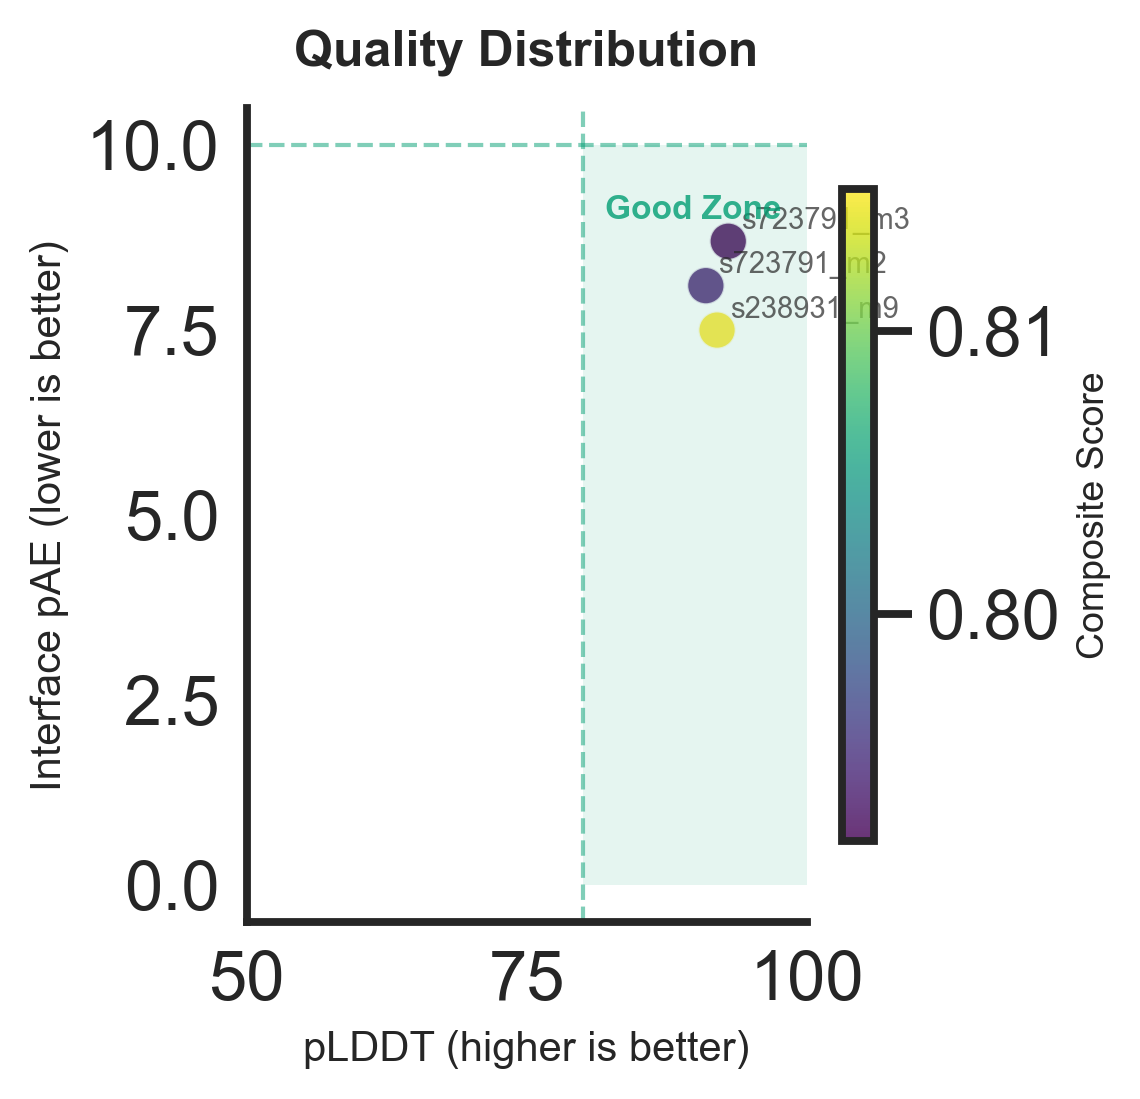


design_ranking:


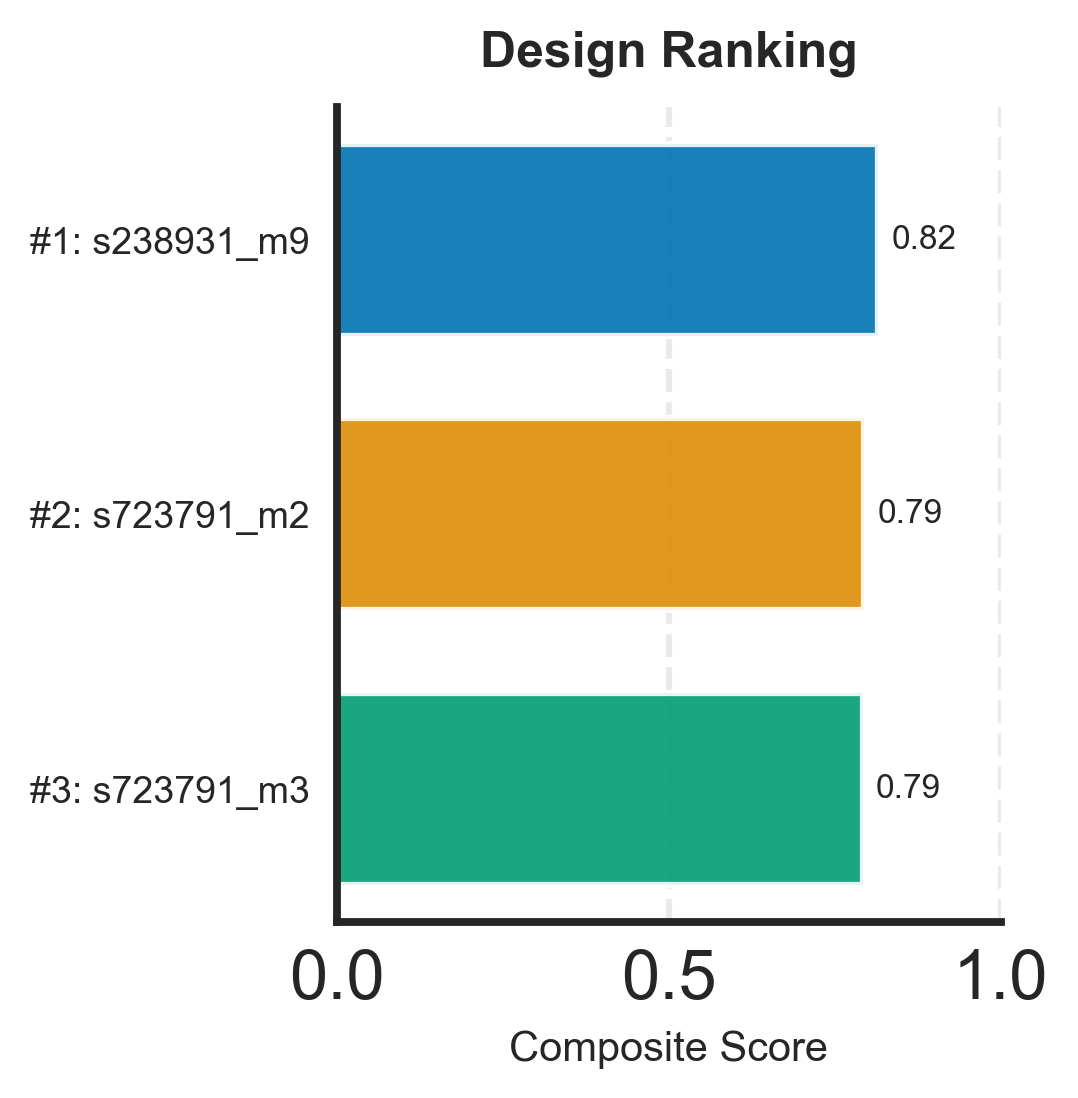


metrics_table:


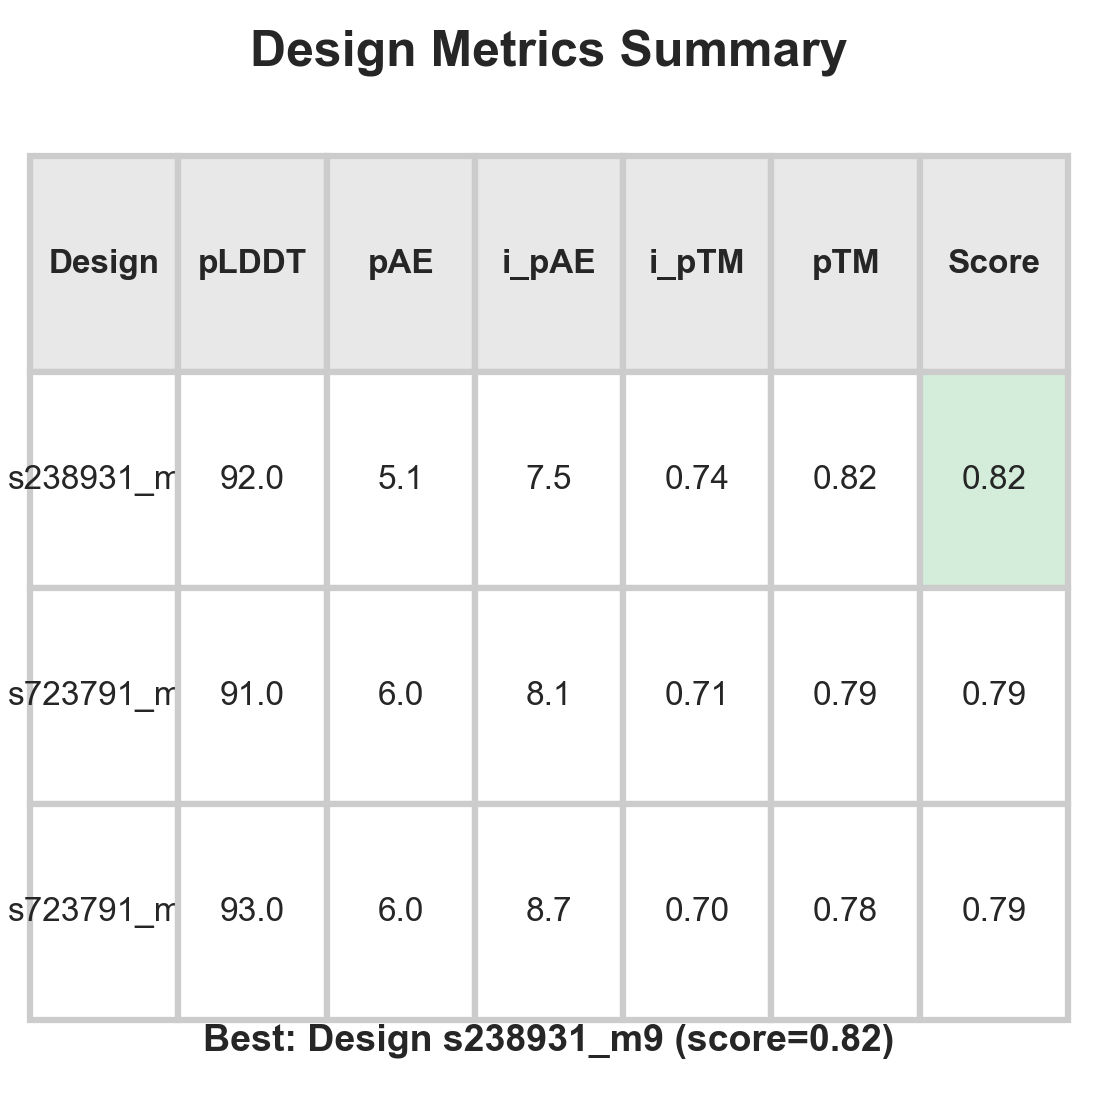


execution_timeline:


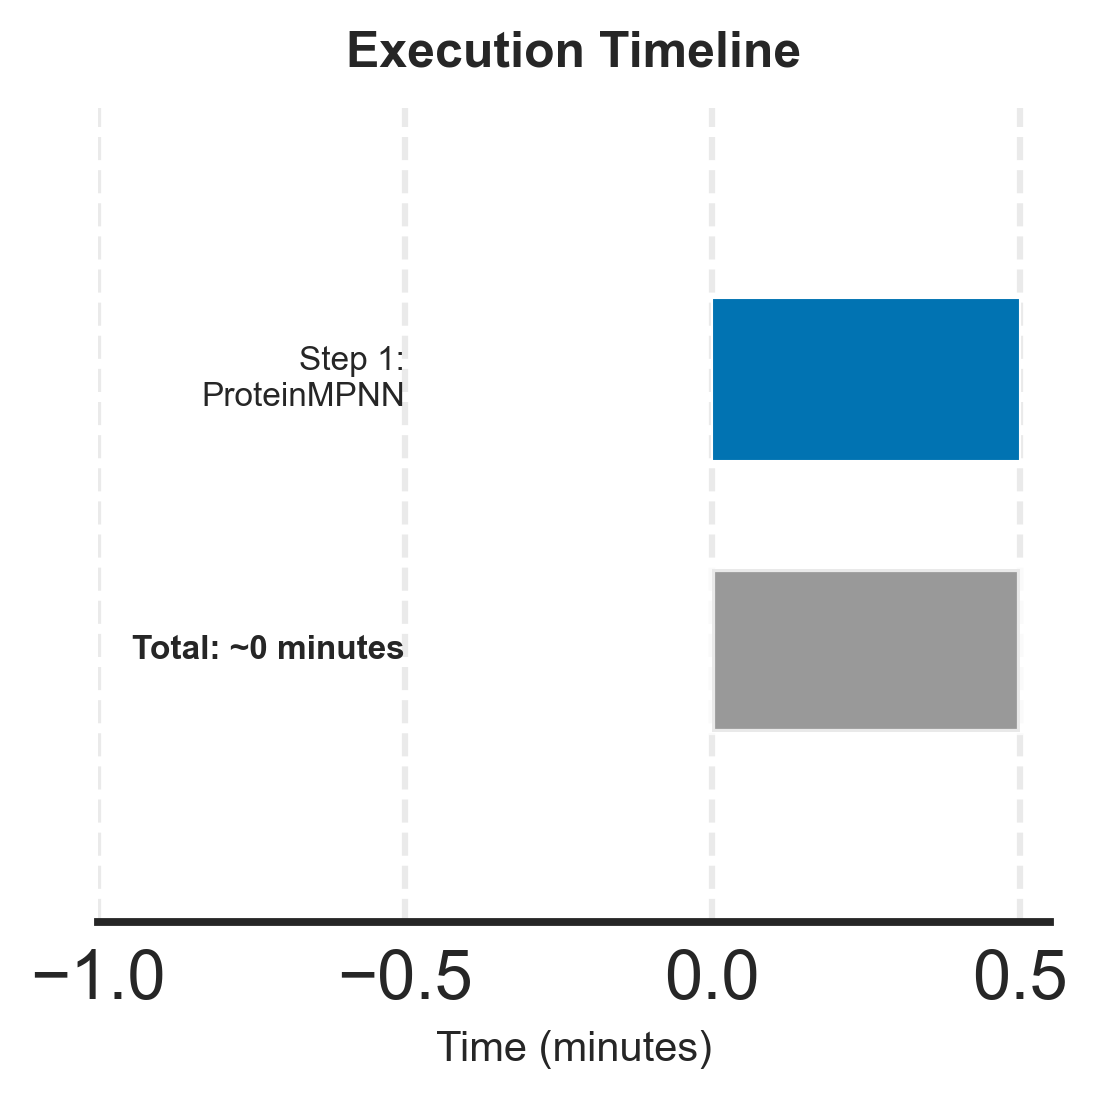


Elapsed: 6.5s


In [12]:
import time
_t0 = time.time()

VIZ_SCRIPT = os.path.join(REPO_DIR, "workflow-skills", "scripts", "binder_design_viz.py")
VIZ_OUTPUT_PREFIX = os.path.join(RESULTS_DIR, "binder_design")

# Install viz deps if needed
run_cmd("pip install -q matplotlib seaborn scipy Pillow pandas")

# Generate separate figures + merged summary
# Point the viz script at BINDCRAFT_OUTPUT_DIR (where final_design_stats.csv lives)
# Save figures to RESULTS_DIR with a custom prefix
run_cmd(f"python {VIZ_SCRIPT} {BINDCRAFT_OUTPUT_DIR} --output {VIZ_OUTPUT_PREFIX}")
run_cmd(f"python {VIZ_SCRIPT} {BINDCRAFT_OUTPUT_DIR} --output {VIZ_OUTPUT_PREFIX}_summary --merged")

# Display figures inline
from IPython.display import display, Image

# Try merged summary first
summary_png = f"{VIZ_OUTPUT_PREFIX}_summary.png"
if os.path.exists(summary_png):
    print("\nMerged summary figure:")
    display(Image(filename=summary_png, width=900))

# Also display individual figures
fig_suffixes = [
    "plddt_comparison",
    "interface_pae",
    "quality_scatter",
    "design_ranking",
    "metrics_table",
    "execution_timeline",
]
for suffix in fig_suffixes:
    fpath = f"{VIZ_OUTPUT_PREFIX}_{suffix}.png"
    if os.path.exists(fpath):
        print(f"\n{suffix}:")
        display(Image(filename=fpath, width=500))

print(f"\nElapsed: {time.time() - _t0:.1f}s")

---
## Instructions & Troubleshooting

### Workflow Overview

This notebook uses BindCraft to design protein binders through an async job pipeline:

1. **Explore Configs** — View available BindCraft configuration templates
2. **Generate Config** — Create an optimized config for your target
3. **Submit Job** — Launch an async GPU design job (RFdiffusion + ProteinMPNN + AlphaFold2)
4. **Monitor Progress** — Check status via MCP + poll logs until completion
5. **Retrieve Results** — Load design metrics and list ranked PDB files
6. **Visualize** — Generate quality assessment figures

### Output Directory Structure

BindCraft writes results to `design_path` from `target_settings.json` (typically `config/job_output/`):

```
RESULTS_DIR/
├── config/
│   ├── target_settings.json        # BindCraft target settings
│   └── job_output/                 # BindCraft output (BINDCRAFT_OUTPUT_DIR)
│       ├── Accepted/Ranked/        # Final ranked PDB files
│       ├── final_design_stats.csv  # Accepted design metrics
│       ├── mpnn_design_stats.csv   # All MPNN design metrics
│       ├── trajectory_stats.csv    # Trajectory statistics
│       └── bindcraft_run.log       # Execution log
└── binder_design_*.png             # Visualization figures
```

### Available MCP Tools

| Tool | Description |
|------|-------------|
| `mcp__bindcraft_mcp__generate_config` | Analyze PDB and generate config directory |
| `mcp__bindcraft_mcp__validate_config` | Validate config before submission |
| `mcp__bindcraft_mcp__bindcraft_submit` | Submit async design job |
| `mcp__bindcraft_mcp__bindcraft_check_status` | Check job status and design counts |
| `mcp__bindcraft_mcp__bindcraft_design_binder` | Run synchronous design (blocking) |

### Common Issues

| Problem | Solution |
|---------|----------|
| `bindcraft_mcp` not found | Run `pmcp install bindcraft_mcp` to pull Docker image |
| Job stuck in pending | Check GPU availability and Docker GPU runtime |
| Low quality designs (low pLDDT) | Try different binder lengths or specify hotspot residues |
| GPU out of memory | Reduce binder length or use smaller model config |
| Config generation fails | Verify chain IDs exist in PDB; try default settings |
| Empty final_design_stats.csv | Designs didn't pass filters; check `failure_csv.csv` |
| Docker image pull timeout | Build locally: `cd tool-mcps/bindcraft_mcp && docker build -t bindcraft_mcp:latest .` |
| Visualization fails | Ensure viz script points at `BINDCRAFT_OUTPUT_DIR`, not `RESULTS_DIR` |

### Quality Thresholds

| Metric | Good | Acceptable | Description |
|--------|------|------------|-------------|
| pLDDT | ≥80 | ≥70 | Predicted structure confidence (higher is better) |
| pAE | ≤5 | ≤10 | Predicted aligned error (lower is better) |
| i_pAE | ≤10 | ≤15 | Interface pAE (lower is better) |
| i_pTM | ≥0.6 | ≥0.4 | Interface pTM score (higher is better) |

### References

- [BindCraft](https://github.com/martinpacesa/BindCraft) — De novo binder design
- [RFdiffusion](https://github.com/RosettaCommons/RFdiffusion) — Structure diffusion
- [ProteinMPNN](https://github.com/dauparas/ProteinMPNN) — Inverse folding
- [AlphaFold](https://github.com/google-deepmind/alphafold) — Structure prediction
- [ProteinMCP](https://github.com/charlesxu90/ProteinMCP) — This project